In [20]:
import glob
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt

from copy import copy
from unidecode import unidecode
from scipy.stats import pearsonr

from bias_correction import BiasCorrection

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

relevant_municipalities = ["buenos aires coronel dorrego", "buenos aires hipolito yrigoyen"]

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read data

**Polygon shapes**

In [21]:
# polygon shapes of the two municipalities that are relevant for the forecast model
gdf_adm2 = gp.read_file("data/shapefile/arg_admbnda_adm2_unhcr2017.shp")[["ADM1_ES", "ADM2_ES", "geometry"]]
gdf_adm2["name"] = gdf_adm2["ADM1_ES"] + " " + gdf_adm2["ADM2_ES"]
gdf_adm2["name"] = gdf_adm2["name"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(["buenos aires coronel dorrego", "buenos aires hipolito yrigoyen"]), ["name", "geometry"]].reset_index(drop=True)
name_to_shape = gdf_adm2.set_index("name")["geometry"].to_dict()

name_to_shape

{'buenos aires coronel dorrego': <POLYGON Z ((-61.175 -38.293 0, -61.174 -38.293 0, -61.173 -38.293 0, -61.17...>,
 'buenos aires hipolito yrigoyen': <POLYGON Z ((-61.45 -36.052 0, -61.435 -36.039 0, -61.393 -36.072 0, -61.333...>}

**ERA data**

In [22]:
era = pd.read_csv("data/era_filtered_locations.csv").assign(model="ERA", init_month=12)
era["name"] = era["name"].apply(lambda x: x.replace("buenos aires ", ""))
era.head()

,name,month,year,rain,tmean,model,init_month
0,coronel dorrego,8,1993,0.000204,10.112333,ERA,12
1,coronel dorrego,8,1994,0.001294,9.102000,ERA,12
2,coronel dorrego,8,1995,0.001060,8.553833,ERA,12
3,coronel dorrego,8,1996,0.003406,11.398833,ERA,12
4,coronel dorrego,8,1997,0.001251,9.445500,ERA,12


**Hindcast data**

In [23]:
# Hindcasts
all_files = glob.glob("data/hindcasts/*.csv")
li = []
for _, filename in enumerate(all_files):
    observations = pd.read_csv(filename)
    observations = observations.loc[(observations["forecasted_month"].between(8,11))].reset_index(drop=True)
    observations = observations.rename(columns={"t2m":"tmean", "prec":"rain"})
    observations["rain"] = observations["rain"] / 1000
    li.append(observations)
    
hindcasts = pd.concat(li, axis=0, ignore_index=False).drop("province", axis=1)
hindcasts = gp.GeoDataFrame(hindcasts, geometry=gp.points_from_xy(hindcasts["lon"], hindcasts["lat"]), crs="EPSG:4326")
hindcasts.head()

,model,init_year,init_month,forecasted_year,forecasted_month,lat,lon,rain,tmean,geometry
0,BOM,1993,4,1993,8,-40.0,-62.5,0.00104,8.57,POINT (-62.50000 -40.00000)
1,BOM,1993,4,1993,9,-40.0,-62.5,0.00149,10.58,POINT (-62.50000 -40.00000)
2,BOM,1993,5,1993,8,-40.0,-62.5,0.00093,8.52,POINT (-62.50000 -40.00000)
3,BOM,1993,5,1993,9,-40.0,-62.5,0.00147,10.73,POINT (-62.50000 -40.00000)
4,BOM,1993,5,1993,10,-40.0,-62.5,0.00176,13.12,POINT (-62.50000 -40.00000)


**No hindcast location intersects with the relevant municipalities**

--> For each model, we have to find the closest location to each of the two municipalities

<Axes: >

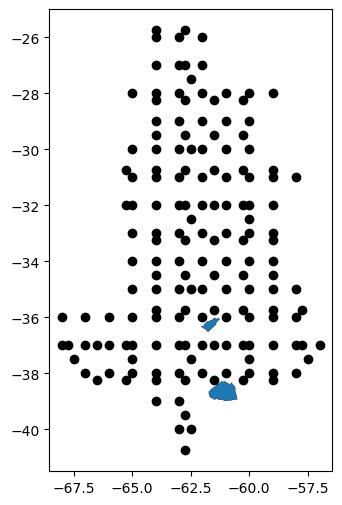

In [24]:
base = gdf_adm2.plot(figsize=(6,6), edgecolor="black", linewidth=.2)
gp.GeoDataFrame(hindcasts.groupby("geometry").size().reset_index(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black")

### 2. Find closest location to municipalities

In [25]:
modelling_groups = hindcasts["model"].unique()
li = []
for model in modelling_groups:
    current_model = hindcasts.loc[hindcasts["model"] == model, ["model", "lat", "lon", "geometry"]].drop_duplicates()
    location_1 = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[relevant_municipalities[0]])[1][0]]).transpose().assign(location="coronel dorrego").reset_index(drop=True)
    location_2 = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[relevant_municipalities[1]])[1][0]]).transpose().assign(location="hipolito yrigoyen").reset_index(drop=True)
    locations = pd.concat([location_1, location_2], ignore_index=True)
    
    current_model = current_model.merge(locations, on=["model", "lat", "lon", "geometry"], how="left").dropna()
    li.append(current_model)
    
model_locations = pd.concat(li, ignore_index=True, axis=0)

<Axes: >

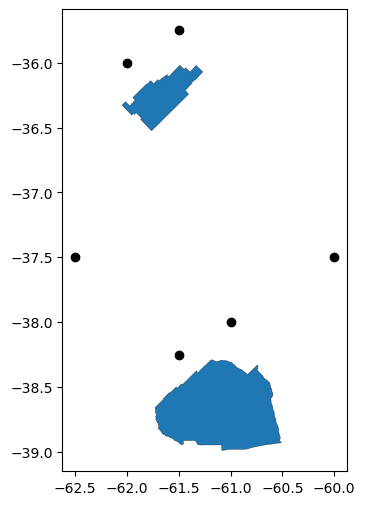

In [26]:
hindcasts = hindcasts.merge(model_locations, on=["model", "lat", "lon", "geometry"]).dropna()

base = gdf_adm2.plot(figsize=(6,6), edgecolor="black", linewidth=.2)
gp.GeoDataFrame(hindcasts.groupby("geometry").size().reset_index(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black")

In [27]:
hindcasts.groupby("model").size()

model
BOM      1104
CMCC     1104
CWB      1104
DWD      1104
ECCC     1104
ECMWF    1104
JMA      1104
KMA      1104
METFR    1104
PNU      1104
UKMO     1104
dtype: int64

### 3. Bring dataframe into the right structure

In [28]:
hindcasts = hindcasts[["model", "init_year", "init_month", "forecasted_month", "rain", "tmean", "location"]]
era = era[["model", "year", "init_month", "month", "rain", "tmean", "name"]]

hindcasts.columns = ["model", "year", "init_month", "forecasted_month", "rain", "tmean", "location"]
era.columns = ["model", "year", "init_month", "forecasted_month", "rain", "tmean", "location"]

In [29]:
era.head(2)

,model,year,init_month,forecasted_month,rain,tmean,location
0,ERA,1993,12,8,0.000204,10.112333,coronel dorrego
1,ERA,1994,12,8,0.001294,9.102000,coronel dorrego


In [30]:
hindcasts.head(2)

,model,year,init_month,forecasted_month,rain,tmean,location
0,BOM,1993,4,8,0.00134,8.79,hipolito yrigoyen
1,BOM,1993,4,9,0.00212,11.22,hipolito yrigoyen


In [46]:
def adjust_temperature_bias(observed, predicted, correction_method="basic_quantile"):
    """Apply bias-adjustment to daily temperature values of hindcasts.
    
    parameters:
     - observed: observed climate data
     - predicted: hindcast data
     - correction_method: bias-correction method to be applied. Can be 'normal_mapping', 'basic_quantile', 'gamma_mapping', 'modified_quantile'
    
    returns: 
     - results: bias-adjusted hindcasts as dataframe  
    """
    # GroupBy objects allow faster access to relevant subsets of climate data.
    grouped_climate_observations = observed.groupby(["location", "year", "forecasted_month"])
    grouped_climate_hindcasts = predicted.groupby(["model", "init_month", "location", "year", "forecasted_month"])
    grouped_climate_hindcasts_reference = copy(grouped_climate_hindcasts)
    li = []
    
    for group_idx, group_content in grouped_climate_hindcasts:
        # Save group characteristics in intuitive variables.
        current_model = group_content["model"].unique()[0]
        current_init_month = group_content["init_month"].unique()[0]
        current_zone = group_content["location"].unique()[0]
        current_season = group_content["year"].unique()[0]
        current_month = group_content["forecasted_month"].unique()[0]
        
        # Create calibration set of observations and hindcasts.
        hindcasts_used_as_reference = []
        observations_used_as_reference = []
        for season in list(range(1993,2017)): 
            if season != current_season:
                observation_to_be_added = (current_zone, season, current_month) 
                observations_used_as_reference.append(grouped_climate_observations.get_group(observation_to_be_added))   
            hindcast_to_be_added = (current_model, current_init_month, current_zone, season, current_month)
            hindcasts_used_as_reference.append(grouped_climate_hindcasts_reference.get_group(hindcast_to_be_added))
        hindcasts_used_as_reference = pd.concat(hindcasts_used_as_reference, axis=0, ignore_index=False)
        observations_used_as_reference = pd.concat(observations_used_as_reference, axis=0, ignore_index=False) 
        
        # Perform bias-adjustment for temperature variables.
        bc_tmean = BiasCorrection(observations_used_as_reference["tmean"], hindcasts_used_as_reference["tmean"], group_content["tmean"])
        #bc_rain = BiasCorrection(observations_used_as_reference["rain"], hindcasts_used_as_reference["rain"], group_content["rain"])
        group_content["tmean"] = bc_tmean.correct(method=correction_method)
        #group_content["rain"] = bc_rain.correct(method=correction_method)
        
        li.append(group_content)
    result = pd.concat(li, axis=0, ignore_index=True)       
    
    return result

adjusted_hindcasts = adjust_temperature_bias(era, hindcasts)

In [47]:
adjusted_hindcasts.sort_values(by=["location", "model", "year", "init_month", "forecasted_month"]).head()

,model,year,init_month,forecasted_month,rain,tmean,location
0,BOM,1993,4,8,0.00173,8.909222,coronel dorrego
1,BOM,1993,4,9,0.00226,10.353958,coronel dorrego
96,BOM,1993,5,8,0.00146,8.074806,coronel dorrego
97,BOM,1993,5,9,0.00209,10.217639,coronel dorrego
98,BOM,1993,5,10,0.00260,13.047250,coronel dorrego


In [48]:
hindcasts.sort_values(by=["location", "model", "year", "init_month", "forecasted_month"]).head()

,model,year,init_month,forecasted_month,rain,tmean,location
552,BOM,1993,4,8,0.00173,8.54,coronel dorrego
553,BOM,1993,4,9,0.00226,10.73,coronel dorrego
554,BOM,1993,5,8,0.00146,8.20,coronel dorrego
555,BOM,1993,5,9,0.00209,10.89,coronel dorrego
556,BOM,1993,5,10,0.00260,13.27,coronel dorrego


In [49]:
adjusted_hindcasts = adjusted_hindcasts.pivot(index=["model", "year", "init_month"], columns=["location", "forecasted_month"], values=["tmean", "rain"]).reset_index()
adjusted_hindcasts.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in adjusted_hindcasts.columns]
adjusted_hindcasts

,model__,year__,init_month__,tmean_coronel dorrego_8,tmean_coronel dorrego_9,tmean_hipolito yrigoyen_8,tmean_hipolito yrigoyen_9,tmean_coronel dorrego_10,tmean_hipolito yrigoyen_10,tmean_coronel dorrego_11,tmean_hipolito yrigoyen_11,rain_coronel dorrego_8,rain_coronel dorrego_9,rain_hipolito yrigoyen_8,rain_hipolito yrigoyen_9,rain_coronel dorrego_10,rain_hipolito yrigoyen_10,rain_coronel dorrego_11,rain_hipolito yrigoyen_11
0,BOM,1993,4,8.909222,10.353958,9.397724,11.163878,NaN,NaN,NaN,NaN,0.001730,0.002260,0.001340,0.002120,NaN,NaN,NaN,NaN
1,BOM,1993,5,8.074806,10.217639,8.694808,11.192628,13.047250,14.695577,NaN,NaN,0.001460,0.002090,0.001110,0.001820,0.002600,0.002870,NaN,NaN
2,BOM,1993,6,8.498333,10.160139,9.097308,11.068045,12.614556,14.558686,16.627139,17.687404,0.001390,0.002260,0.001110,0.002090,0.003220,0.002960,0.003250,0.003320
3,BOM,1993,7,8.342500,10.073889,8.632051,10.847628,12.758306,14.530577,16.599639,17.389904,0.001940,0.002510,0.001590,0.002430,0.002460,0.002380,0.003400,0.003470
4,BOM,1993,8,7.365639,9.939722,7.947308,10.828462,12.480389,14.213686,16.376875,17.585385,0.001360,0.002280,0.000880,0.002140,0.003270,0.003230,0.003260,0.003030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,UKMO,2016,7,11.057973,12.198743,11.084470,12.964740,16.652167,17.407359,18.626748,19.742997,0.001983,0.002343,0.002138,0.002399,0.002633,0.003069,0.002926,0.003105
2108,UKMO,2016,8,10.202363,12.723713,10.523133,13.443045,15.166891,16.801351,18.080879,18.635620,0.001253,0.001736,0.001035,0.001940,0.003470,0.004190,0.002345,0.004408
2109,UKMO,2016,9,NaN,11.696638,NaN,12.469541,15.925640,17.145535,19.396775,20.438436,NaN,0.001997,NaN,0.001855,0.001994,0.002352,0.002462,0.003111
2110,UKMO,2016,10,NaN,NaN,NaN,NaN,15.925324,17.153843,18.376588,19.639421,NaN,NaN,NaN,NaN,0.004086,0.005379,0.003182,0.003981


In [50]:
era_adjusted = era.pivot(index=["model", "year", "init_month"], columns=["location", "forecasted_month"], values=["tmean", "rain"]).reset_index()
era_adjusted.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in era_adjusted.columns]
era_adjusted.head()

,model__,year__,init_month__,tmean_coronel dorrego_8,tmean_coronel dorrego_9,tmean_coronel dorrego_10,tmean_coronel dorrego_11,tmean_hipolito yrigoyen_8,tmean_hipolito yrigoyen_9,tmean_hipolito yrigoyen_10,tmean_hipolito yrigoyen_11,rain_coronel dorrego_8,rain_coronel dorrego_9,rain_coronel dorrego_10,rain_coronel dorrego_11,rain_hipolito yrigoyen_8,rain_hipolito yrigoyen_9,rain_hipolito yrigoyen_10,rain_hipolito yrigoyen_11
0,ERA,1993,12,10.112333,11.635667,14.787833,16.469500,10.272308,11.610769,16.042308,17.662308,0.000204,0.000629,0.001886,0.002961,0.000622,0.002687,0.002157,0.005082
1,ERA,1994,12,9.102000,11.997500,13.506667,19.338333,9.853077,12.882308,14.715385,19.764615,0.001294,0.000819,0.001880,0.001744,0.002331,0.001586,0.002564,0.001845
2,ERA,1995,12,8.553833,11.863667,14.151667,18.022500,9.418462,13.288462,15.503846,19.739231,0.001060,0.000536,0.002009,0.003304,0.000590,0.001148,0.002388,0.004076
3,ERA,1996,12,11.398833,11.581000,15.138333,18.581000,12.302308,12.624615,16.642308,19.933846,0.003406,0.000632,0.003675,0.003039,0.001807,0.001189,0.003135,0.003330
4,ERA,1997,12,9.445500,10.045667,13.813500,16.640667,10.813077,11.807692,14.850000,17.690769,0.001251,0.001325,0.003286,0.002113,0.001689,0.001448,0.006382,0.004226


In [51]:
all_models = adjusted_hindcasts.set_index("year__").combine_first(era_adjusted.set_index("year__")).reset_index()
all_models.columns = [c.strip("_") for c in all_models.columns]
all_models = all_models.sort_values(by=["model", "year", "init_month"])

all_models = all_models[['model', 'year', 'init_month', 'rain_coronel dorrego_10', 'rain_coronel dorrego_11', 'rain_coronel dorrego_8', 'rain_coronel dorrego_9', 
                         'rain_hipolito yrigoyen_10', 'rain_hipolito yrigoyen_11', 'rain_hipolito yrigoyen_8', 'rain_hipolito yrigoyen_9', 'tmean_coronel dorrego_10', 
                         'tmean_coronel dorrego_11', 'tmean_coronel dorrego_8', 'tmean_coronel dorrego_9', 'tmean_hipolito yrigoyen_10', 'tmean_hipolito yrigoyen_11', 
                         'tmean_hipolito yrigoyen_8', 'tmean_hipolito yrigoyen_9']]
all_models.head()

,model,year,init_month,rain_coronel dorrego_10,rain_coronel dorrego_11,rain_coronel dorrego_8,rain_coronel dorrego_9,rain_hipolito yrigoyen_10,rain_hipolito yrigoyen_11,rain_hipolito yrigoyen_8,rain_hipolito yrigoyen_9,tmean_coronel dorrego_10,tmean_coronel dorrego_11,tmean_coronel dorrego_8,tmean_coronel dorrego_9,tmean_hipolito yrigoyen_10,tmean_hipolito yrigoyen_11,tmean_hipolito yrigoyen_8,tmean_hipolito yrigoyen_9
0,BOM,1993,4,0.001886,0.002961,0.00173,0.00226,0.002157,0.005082,0.00134,0.00212,14.787833,16.469500,8.909222,10.353958,16.042308,17.662308,9.397724,11.163878
1,BOM,1993,5,0.002600,0.002961,0.00146,0.00209,0.002870,0.005082,0.00111,0.00182,13.047250,16.469500,8.074806,10.217639,14.695577,17.662308,8.694808,11.192628
2,BOM,1993,6,0.003220,0.003250,0.00139,0.00226,0.002960,0.003320,0.00111,0.00209,12.614556,16.627139,8.498333,10.160139,14.558686,17.687404,9.097308,11.068045
3,BOM,1993,7,0.002460,0.003400,0.00194,0.00251,0.002380,0.003470,0.00159,0.00243,12.758306,16.599639,8.342500,10.073889,14.530577,17.389904,8.632051,10.847628
4,BOM,1993,8,0.003270,0.003260,0.00136,0.00228,0.003230,0.003030,0.00088,0.00214,12.480389,16.376875,7.365639,9.939722,14.213686,17.585385,7.947308,10.828462


In [52]:
era_adjusted.columns = [c.strip("_") for c in era_adjusted.columns]
era_adjusted = era_adjusted.sort_values(by=["model", "year", "init_month"])

era_adjusted = era_adjusted[['model', 'year', 'init_month', 'rain_coronel dorrego_10', 'rain_coronel dorrego_11', 'rain_coronel dorrego_8', 'rain_coronel dorrego_9', 
                         'rain_hipolito yrigoyen_10', 'rain_hipolito yrigoyen_11', 'rain_hipolito yrigoyen_8', 'rain_hipolito yrigoyen_9', 'tmean_coronel dorrego_10', 
                         'tmean_coronel dorrego_11', 'tmean_coronel dorrego_8', 'tmean_coronel dorrego_9', 'tmean_hipolito yrigoyen_10', 'tmean_hipolito yrigoyen_11', 
                         'tmean_hipolito yrigoyen_8', 'tmean_hipolito yrigoyen_9']]
era_adjusted.head()

,model,year,init_month,rain_coronel dorrego_10,rain_coronel dorrego_11,rain_coronel dorrego_8,rain_coronel dorrego_9,rain_hipolito yrigoyen_10,rain_hipolito yrigoyen_11,rain_hipolito yrigoyen_8,rain_hipolito yrigoyen_9,tmean_coronel dorrego_10,tmean_coronel dorrego_11,tmean_coronel dorrego_8,tmean_coronel dorrego_9,tmean_hipolito yrigoyen_10,tmean_hipolito yrigoyen_11,tmean_hipolito yrigoyen_8,tmean_hipolito yrigoyen_9
0,ERA,1993,12,0.001886,0.002961,0.000204,0.000629,0.002157,0.005082,0.000622,0.002687,14.787833,16.469500,10.112333,11.635667,16.042308,17.662308,10.272308,11.610769
1,ERA,1994,12,0.001880,0.001744,0.001294,0.000819,0.002564,0.001845,0.002331,0.001586,13.506667,19.338333,9.102000,11.997500,14.715385,19.764615,9.853077,12.882308
2,ERA,1995,12,0.002009,0.003304,0.001060,0.000536,0.002388,0.004076,0.000590,0.001148,14.151667,18.022500,8.553833,11.863667,15.503846,19.739231,9.418462,13.288462
3,ERA,1996,12,0.003675,0.003039,0.003406,0.000632,0.003135,0.003330,0.001807,0.001189,15.138333,18.581000,11.398833,11.581000,16.642308,19.933846,12.302308,12.624615
4,ERA,1997,12,0.003286,0.002113,0.001251,0.001325,0.006382,0.004226,0.001689,0.001448,13.813500,16.640667,9.445500,10.045667,14.850000,17.690769,10.813077,11.807692


In [53]:
all_models = pd.concat([all_models, era_adjusted], ignore_index=True)
all_models = all_models.sort_values(by=["model", "year", "init_month"])

In [54]:
all_models.to_csv("data/hindcast_no_rain_ba_era_features.csv", index=False)